In [1]:
from config import*
from SPP_problem import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


family_len:  3079


In [2]:
WPINN_model = WPINN(input_size = n_collocation, 
                    num_hidden_layers = 6, 
                    hidden_neurons = 100, 
                    family_size = len_family).to(device)

optimizer = optim.Adam(WPINN_model.parameters(), lr=1e-5)

In [3]:
t_interior = t_collocation.clone()

def wpinn_loss():   

    global c,b
    c, b = WPINN_model(t_interior)

    u  = torch.mv(Wfamily, c) + b
    u_t = torch.mv(DWt, c)
    u_tt = torch.mv(DW2t, c)

    u_pred_ic = torch.mv(Wic, c) + b
    Du_pred_ic = torch.mv(DWic, c)
    
    pde_loss = torch.mean((e*u_tt + (3+t_collocation)*u_t + u**2 - torch.sin(u) - rhs) ** 2)   

    ic_loss = torch.mean((u_pred_ic - u_ic) ** 2) + \
              torch.mean((Du_pred_ic - Du_ic) ** 2)
    
    total_loss = pde_loss + ic_loss
    
    return total_loss, pde_loss, ic_loss

def train_wpinn(num_epochs, num_prints):

    for epoch in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        total_loss, pde_loss, ic_loss = wpinn_loss()
        
        total_loss.backward()
        optimizer.step()

    
        if epoch % ((num_epochs-1)/num_prints) == 0:  # Print every num_prints epochs
            
            with torch.no_grad():
                numerical = torch.mv(Wval, c.cpu()) + b.cpu()
                errL2 = (torch.sum(torch.abs(exact-numerical)**2))**0.5 / (torch.sum(torch.abs(exact)**2))**0.5
                errMax = torch.max(torch.abs(exact-numerical))

            print(f'Epoch [{epoch}/{num_epochs}], '
                f'Total Loss: {total_loss.item():.6f}, '
                f'PDE Loss: {pde_loss.item():.6f}, '
                f'IC Loss: {ic_loss.item():.6f}\n\t\t'
                f'RelativeL2: {errL2},\t\t'
                f'Max: {errMax}\n' )
            
        torch.cuda.empty_cache()

In [4]:
num_epochs = 10**5+1 
num_prints = 5
train_wpinn(num_epochs, num_prints)

  0%|          | 92/100001 [00:00<03:23, 490.94it/s]

Epoch [0/100001], Total Loss: 4858252.500000, PDE Loss: 4856701.000000, IC Loss: 1551.343140
		RelativeL2: 0.7570815086364746,		Max: 2.5678768157958984



 20%|██        | 20092/100001 [00:30<02:01, 655.51it/s]

Epoch [20000/100001], Total Loss: 24.419327, PDE Loss: 22.410624, IC Loss: 2.008703
		RelativeL2: 0.4498259127140045,		Max: 1.4195576906204224



 40%|████      | 40090/100001 [01:01<01:32, 650.33it/s]

Epoch [40000/100001], Total Loss: 0.658553, PDE Loss: 0.658542, IC Loss: 0.000011
		RelativeL2: 0.00046082347398623824,		Max: 0.00188446044921875



 60%|██████    | 60075/100001 [01:31<01:01, 651.09it/s]

Epoch [60000/100001], Total Loss: 1.338876, PDE Loss: 1.338763, IC Loss: 0.000113
		RelativeL2: 0.00019752939988393337,		Max: 0.0008780956268310547



 80%|████████  | 80095/100001 [02:02<00:30, 648.50it/s]

Epoch [80000/100001], Total Loss: 0.288708, PDE Loss: 0.288682, IC Loss: 0.000027
		RelativeL2: 0.0006278430810198188,		Max: 0.0018711090087890625



 82%|████████▏ | 81933/100001 [02:05<00:27, 652.51it/s]


KeyboardInterrupt: 

RelativeL2: 5.8127217926084995e-05,		 Max: 0.0002295970916748047



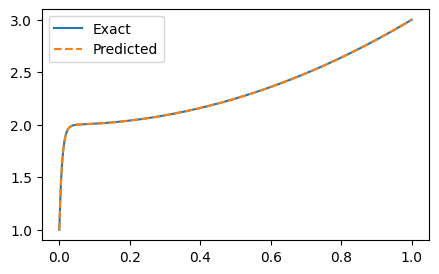

In [5]:
# Testing and Plotting
u_pred = (torch.mv(Wtest, c.cpu()) + b.cpu()).detach().numpy()
errL2 = (np.sum(np.abs(u_exact-u_pred)**2))**0.5 / (np.sum(np.abs(u_exact)**2))**0.5
errMax = np.max(np.abs(u_exact-u_pred))

print(f'RelativeL2: {errL2},\t\t', f'Max: {errMax}\n' )


fig = plt.figure(figsize=(5,3))
plt.plot(t_test, u_exact, label='Exact')
plt.plot(t_test, u_pred, '--', label='Predicted')
plt.legend()
plt.show()
